In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np 
import matplotlib.pyplot as plt
import random

# Pre Processing

In [15]:
# Download MNIST dataset if not already downloaded
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_data = []
train_classes = []

# He Normalize the train_dataset
mean = train_dataset.data.float().mean()/255.0
std = train_dataset.data.float().std()/255.0

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Apply normalization to train_dataset
train_dataset.transform = train_transform

# Apply normalization to test_dataset as well
test_dataset.transform = train_transform

In [16]:
# Sample the data for 10000 with 1000 for each class
for class_label in range(10):
    indices = torch.where(train_dataset.targets == class_label)[0][:1000]
    train_data.append(train_dataset.data[indices])
    train_classes.append(train_dataset.targets[indices])

train_data = torch.cat(train_data, dim=0)
train_classes = torch.cat(train_classes, dim=0)
train_data = train_data.float() / 255.0
X_test = test_dataset.data.float() / 255.0

In [17]:
# Print all 10 classes
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [18]:
def PrintImages(train_dataset):
    # Create a dictionary to store one image per class
    class_images = {}

    # Iterate over the dataset and select one image from each class
    for i in range(len(train_dataset)):
        image, label = train_dataset[i]
        class_name = classes[label]

        # If the class image is not already stored, add it to the dictionary
        if class_name not in class_images:
            class_images[class_name] = image
            if len(class_images) == len(classes):
                break

    # Plot one image from each class using Matplotlib
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.tight_layout()

    for i, class_name in enumerate(class_images.keys()):
        image = class_images[class_name]
        row = i // 5
        col = i % 5
        axs[row, col].imshow(image.permute(1, 2, 0))
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')

    plt.show()

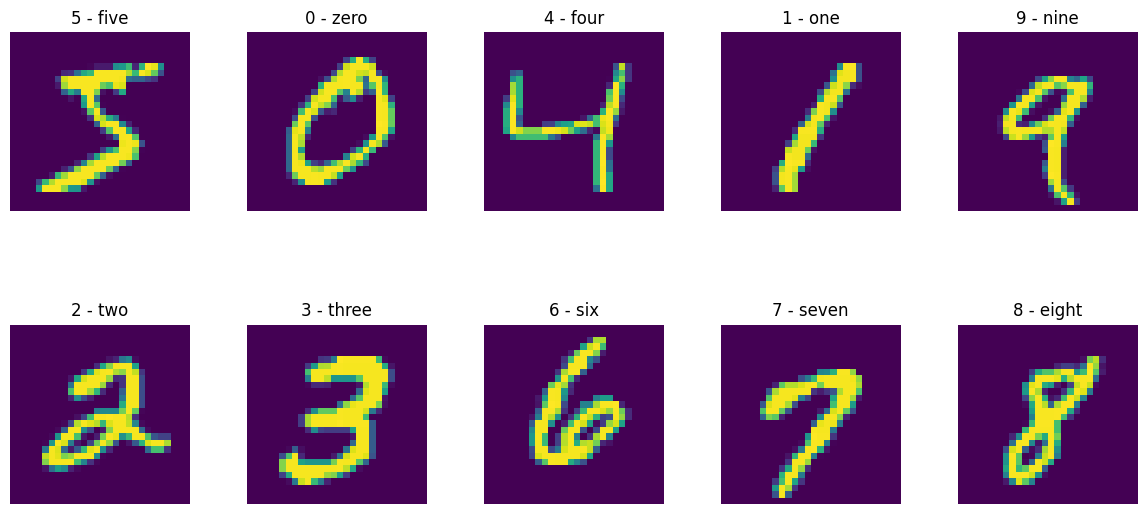

In [19]:
PrintImages(train_dataset)

In [ ]:
#Flatten the data
train_data = train_data.view(-1, 784)
X_test = X_test.view(-1, 784)

In [5]:
#One Hot Encoding
y_train_oh = torch.nn.functional.one_hot(train_classes, 10)
y_test_oh = torch.nn.functional.one_hot(test_dataset.targets, 10)

# 1. Setup your code 
so that you can run multiple MNIST models for varying choices of k and p
automatically, Specifically, you need two for loops (one for k and one for p) and within the loop, you
call PyTorch/TensorFlow.

In [4]:
#Neural Network
class ShallowNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p):
        super(ShallowNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(1-p)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

In [5]:
def ModelRun(k, p, learning_rate, num_epochs, batch_size):
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #Define the model, loss function, and optimizer											   
    model = ShallowNeuralNet(input_size=784, hidden_size=k, output_size=10,p=p).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=5e-4)

    #Training loop
    total_step = len(train_data)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train = 0
        train_all = 0
        for i in range(0, total_step, batch_size):
            images = train_data.to(device)
            labels = torch.argmax(y_train_oh.to(device), dim=1)

            #Forward pass
            outputs = model(images)
            _, predicted_train = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            #Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_all += labels.size(0)
            train += (predicted_train == labels).sum().item()

        los = train_loss / (len(train_data) // batch_size)
        train_accuracy =  (train / train_all) * 100

        # Evaluation
        model.eval()
        with torch.no_grad():
            test = 0
            test_all = 0
            for i in range(0, len(X_test), batch_size):
                images = X_test.to(device)
                labels = test_dataset.targets.to(device)

                # Forward pass
                outputs = model(images)
                _, predicted_test = torch.max(outputs.data, 1)

                # Count the number of correct predictions
                test_all += labels.size(0)
                test += (predicted_test == labels).sum().item()

            test_accuracy = (test / test_all) * 100

    print(f"Model with k={k}, p={p}: Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    return (train_accuracy, test_accuracy, los)

2. Pick the width grid K = [1, 5, 10, 20, 40] and dropout grid P = [0.1, 0.5, 1.0]. Run MNIST models
over these grids with Adam optimizer for 80 epochs. Store the test/train accuracy and loss

In [ ]:
# Set the hyperparameters
learning_rate = 0.001
num_epochs = 80
batch_size = 32

# Define the choices for k and p
ks = [1, 5, 10, 20, 40]   # Example values, you can adjust them as needed
ps = [0.1, 0.5, 1.0]

train_list = []
test_list = []
loss_list = []

train_accuracy = 0
test_accuracy = 0
loss = 0

# Training loop
for k in ks:
  for p in ps:

    train_accuracy, test_accuracy, loss = ModelRun(k, p, learning_rate, num_epochs, batch_size)

    train_list.append(train_accuracy)
    test_list.append(test_accuracy)
    loss_list.append(loss)

Model with k=1, p=0.1: Training Accuracy: 28.62%, Test Accuracy: 28.94%
Model with k=1, p=0.5: Training Accuracy: 36.29%, Test Accuracy: 35.57%
Model with k=1, p=1.0: Training Accuracy: 36.30%, Test Accuracy: 35.57%
Model with k=5, p=0.1: Training Accuracy: 94.80%, Test Accuracy: 89.32%
Model with k=5, p=0.5: Training Accuracy: 94.71%, Test Accuracy: 89.49%
Model with k=5, p=1.0: Training Accuracy: 94.41%, Test Accuracy: 89.09%
Model with k=10, p=0.1: Training Accuracy: 97.78%, Test Accuracy: 92.65%
Model with k=10, p=0.5: Training Accuracy: 97.60%, Test Accuracy: 92.27%
Model with k=10, p=1.0: Training Accuracy: 97.53%, Test Accuracy: 92.16%
Model with k=20, p=0.1: Training Accuracy: 99.13%, Test Accuracy: 94.59%
Model with k=20, p=0.5: Training Accuracy: 98.77%, Test Accuracy: 94.49%
Model with k=20, p=1.0: Training Accuracy: 98.98%, Test Accuracy: 94.68%
Model with k=40, p=0.1: Training Accuracy: 99.25%, Test Accuracy: 95.50%
Model with k=40, p=0.5: Training Accuracy: 99.23%, Test A

In [ ]:
#Plot the results
print(train_list)
print(test_list)
print(loss_list)

[28.61996805111821, 36.29479233226837, 36.295303514377, 94.79872204472844, 94.71277955271566, 94.41185303514376, 97.77996805111822, 97.59926517571886, 97.53076677316294, 99.13, 98.77, 98.98, 99.2514696485623, 99.23, 99.3]
[28.94, 35.57, 35.57, 89.32, 89.49, 89.09, 92.65, 92.27, 92.16, 94.59, 94.49, 94.68, 95.5, 95.67, 95.59]
[2.167106874478169, 2.123070615224349, 2.123070090244978, 1.541948662736477, 1.542135287171755, 1.544998293885818, 1.5055059316830757, 1.508228416244189, 1.5087259576106682, 1.4902881322762904, 1.4930539257251298, 1.4913688485439007, 1.4870217580061693, 1.4868218994293458, 1.4868397063169725]


In [ ]:
#Re-Initializing manually as runtime disconnected(by GPU on COLAB)
ks = [1, 5, 10, 20, 40]   # Example values, you can adjust them as needed
ps = [0.1, 0.5, 1.0]

train_list = [28.61996805111821, 36.29479233226837, 36.295303514377, 94.79872204472844, 94.71277955271566, 94.41185303514376, 97.77996805111822, 97.59926517571886, 97.53076677316294, 99.13, 98.77, 98.98, 99.2514696485623, 99.23, 99.3]
test_list = [28.94, 35.57, 35.57, 89.32, 89.49, 89.09, 92.65, 92.27, 92.16, 94.59, 94.49, 94.68, 95.5, 95.67, 95.59]
loss_list = [2.167106874478169, 2.123070615224349, 2.123070090244978, 1.541948662736477, 1.542135287171755, 1.544998293885818, 1.5055059316830757, 1.508228416244189, 1.5087259576106682, 1.4902881322762904, 1.4930539257251298, 1.4913688485439007, 1.4870217580061693, 1.4868218994293458, 1.4868397063169725]

In [ ]:
#Split the train list
train_p_1 = []
test_p_1 = []
train_p_01 = []
test_p_01 = []
train_p_05 = []
test_p_05 = []

for i in range(0, len(train_list)):
    if i % 3 == 0:
        train_p_01.append(train_list[i])
        test_p_01.append(test_list[i])
    elif i % 3 == 1:
        train_p_05.append(train_list[i])
        test_p_05.append(test_list[i])
    else:
        train_p_1.append(train_list[i])
        test_p_1.append(test_list[i])


# 2.a. Train, Test Accuracy vs K Plot with P=1.0

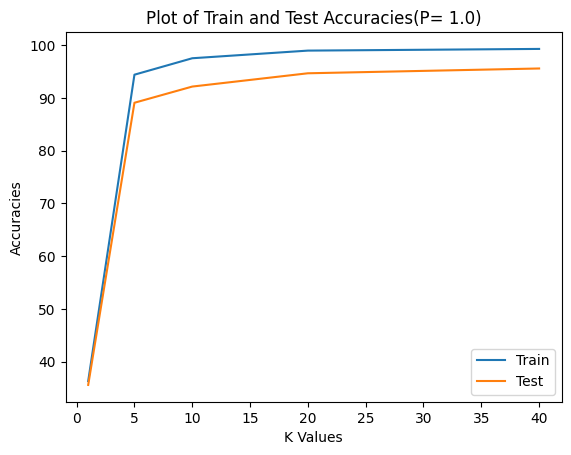

[36.295303514377, 94.41185303514376, 97.53076677316294, 98.98, 99.3]


In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(ks, train_p_1, label='Train')
plt.plot(ks, test_p_1, label='Test')

# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Train and Test Accuracies(P= 1.0)')

# Add legend
plt.legend()

# Display the plot
plt.show()

print(train_p_1)

*   Yes the Performance Improves, as we could see from the plot and the list below the plot, with increase in K, Train and Test Accuracies Increases.
*   And at K=40, I'm acheiving 99.3% Train Accuracy.





# 2.b. Train Accuracy Plot

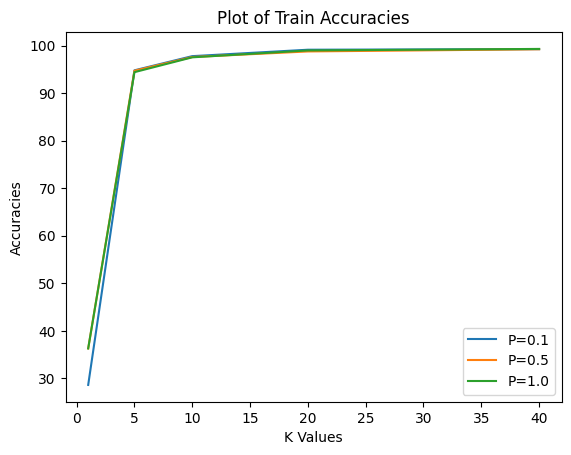

When P = 0.1 [28.61996805111821, 94.79872204472844, 97.77996805111822, 99.13, 99.2514696485623]
When P = 0.5 [36.29479233226837, 94.71277955271566, 97.59926517571886, 98.77, 99.23]
When P = 1 [36.295303514377, 94.41185303514376, 97.53076677316294, 98.98, 99.3]


In [ ]:
# Plotting Train Accuracies
plt.plot(ks, train_p_01, label='P=0.1')
plt.plot(ks, train_p_05, label='P=0.5')
plt.plot(ks, train_p_1, label='P=1.0')


# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Train Accuracies')

# Add legend
plt.legend()

# Display the plot
plt.show()

print("When P = 0.1",train_p_01)
print("When P = 0.5",train_p_05)
print("When P = 1",train_p_1)




*   The role of the dropout rate p is to control the probability of dropping out units during training. A smaller dropout rate means a smaller probability of dropping out units, while a larger dropout rate means a larger probability of dropping out units.

*   It's difficult to optimize model when P is small. his is because smaller values of p result in more units being retained during training, leading to a higher capacity model. A higher capacity model has more parameters to optimize, making it prone to overfitting and slower convergence. Therefore, when p is smaller, the optimization process may be more challenging.

*   For each value of P, When K = 40, I'm able to acheive train accuracy of 99.2 ot 99.3%.



# 2.C. Test Accuracy Plot

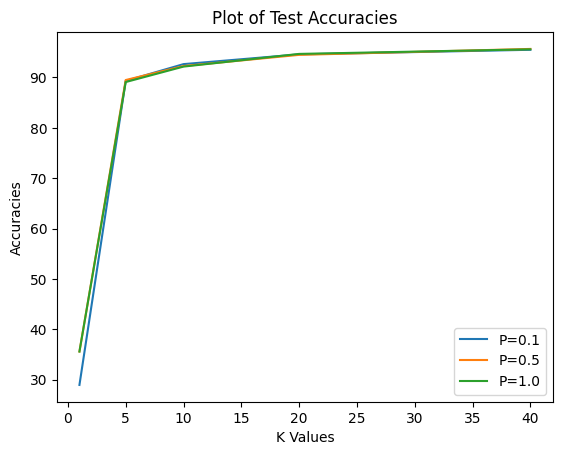

When P = 0.1 [28.94, 89.32, 92.65, 94.59, 95.5]
When P = 0.5 [35.57, 89.49, 92.27, 94.49, 95.67]
When P = 1 [35.57, 89.09, 92.16, 94.68, 95.59]


In [ ]:
# Plotting Train Accuracies
plt.plot(ks, test_p_01, label='P=0.1')
plt.plot(ks, test_p_05, label='P=0.5')
plt.plot(ks, test_p_1, label='P=1.0')


# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Test Accuracies')

# Add legend
plt.legend()

# Display the plot
plt.show()

print("When P = 0.1",test_p_01)
print("When P = 0.5",test_p_05)
print("When P = 1",test_p_1)


From the above plot and list, when P=0.5 and K = 40 I'm able to achieve high test accuracy i.e. 95.67%

# 3. With 40% Noise in Trianing data

In [6]:
#Select 40% of the training examples randomly
num_examples = int(0.4 * len(train_classes))
noisy_indices = random.sample(range(len(train_classes)), num_examples)

#Assign random labels to the selected examples
for idx in noisy_indices:
    new_label = random.choice([label for label in range(10) if label != train_classes[idx]])
    train_classes[idx] = new_label

In [7]:
#One Hot Encoding
y_train_oh = torch.nn.functional.one_hot(train_classes, 10)
y_test_oh = torch.nn.functional.one_hot(test_dataset.targets, 10)

In [9]:
# Set the hyperparameters
learning_rate = 0.001
num_epochs = 80
batch_size = 32

# Define the choices for k and p
ks = [1, 5, 10, 20, 40]   # Example values, you can adjust them as needed
ps = [0.1, 0.5, 1.0]

train_list = []
test_list = []
loss_list = []

train_accuracy = 0
test_accuracy = 0
loss = 0

# Training loop
for k in ks:
  for p in ps:

    train_accuracy, test_accuracy, loss = ModelRun(k, p, learning_rate, num_epochs, batch_size)

    train_list.append(train_accuracy)
    test_list.append(test_accuracy)
    loss_list.append(loss)

Model with k=1, p=0.1: Training Accuracy: 23.82%, Test Accuracy: 34.79%
Model with k=1, p=0.5: Training Accuracy: 23.79%, Test Accuracy: 35.20%
Model with k=1, p=1.0: Training Accuracy: 20.32%, Test Accuracy: 27.99%
Model with k=5, p=0.1: Training Accuracy: 58.32%, Test Accuracy: 87.66%
Model with k=5, p=0.5: Training Accuracy: 58.38%, Test Accuracy: 87.59%
Model with k=5, p=1.0: Training Accuracy: 58.04%, Test Accuracy: 87.66%
Model with k=10, p=0.1: Training Accuracy: 60.88%, Test Accuracy: 90.20%
Model with k=10, p=0.5: Training Accuracy: 60.79%, Test Accuracy: 90.05%
Model with k=10, p=1.0: Training Accuracy: 60.77%, Test Accuracy: 90.05%
Model with k=20, p=0.1: Training Accuracy: 61.99%, Test Accuracy: 90.97%
Model with k=20, p=0.5: Training Accuracy: 62.37%, Test Accuracy: 91.15%
Model with k=20, p=1.0: Training Accuracy: 62.24%, Test Accuracy: 91.42%
Model with k=40, p=0.1: Training Accuracy: 62.59%, Test Accuracy: 92.11%
Model with k=40, p=0.5: Training Accuracy: 62.84%, Test A

In [10]:
#Split the train list
train_p_1 = []
test_p_1 = []
train_p_01 = []
test_p_01 = []
train_p_05 = []
test_p_05 = []

for i in range(0, len(train_list)):
    if i % 3 == 0:
        train_p_01.append(train_list[i])
        test_p_01.append(test_list[i])
    elif i % 3 == 1:
        train_p_05.append(train_list[i])
        test_p_05.append(test_list[i])
    else:
        train_p_1.append(train_list[i])
        test_p_1.append(test_list[i])

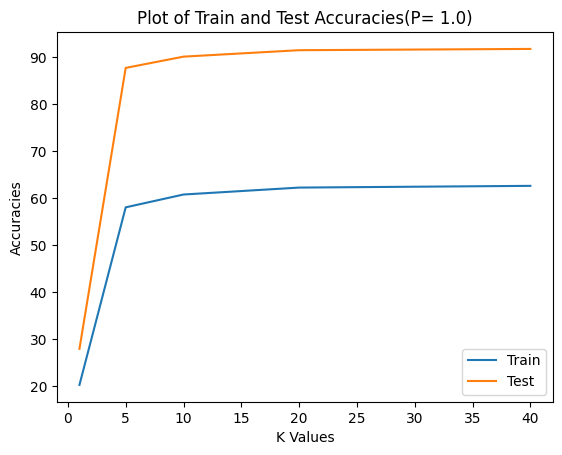

[20.32115015974441, 58.041182108626195, 60.76591054313099, 62.23722044728434, 62.604536741214055]


In [11]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(ks, train_p_1, label='Train')
plt.plot(ks, test_p_1, label='Test')

# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Train and Test Accuracies(P= 1.0)')

# Add legend
plt.legend()

# Display the plot
plt.show()

print(train_p_1)

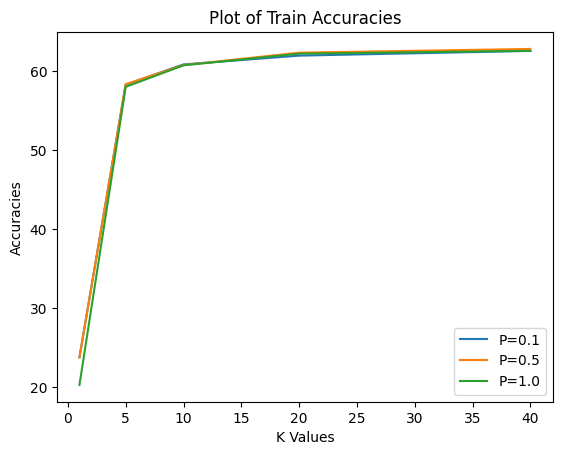

When P = 0.1 [23.821246006389778, 58.3202875399361, 60.87760383386581, 61.99172523961661, 62.59]
When P = 0.5 [23.78702875399361, 58.3776357827476, 60.79, 62.36664536741214, 62.84]
When P = 1 [20.32115015974441, 58.041182108626195, 60.76591054313099, 62.23722044728434, 62.604536741214055]


In [12]:
# Plotting Train Accuracies
plt.plot(ks, train_p_01, label='P=0.1')
plt.plot(ks, train_p_05, label='P=0.5')
plt.plot(ks, train_p_1, label='P=1.0')


# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Train Accuracies')

# Add legend
plt.legend()

# Display the plot
plt.show()

print("When P = 0.1",train_p_01)
print("When P = 0.5",train_p_05)
print("When P = 1",train_p_1)


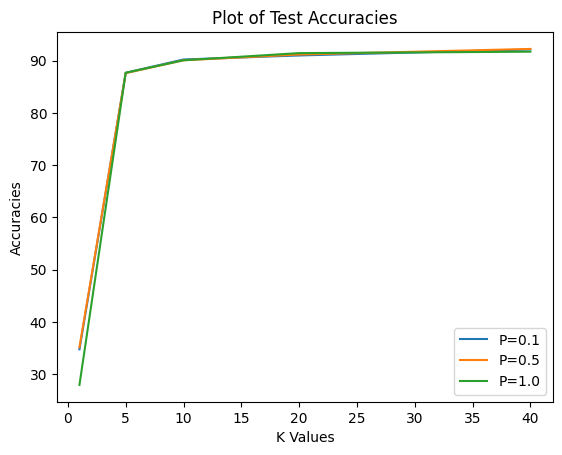

When P = 0.1 [34.79, 87.66, 90.2, 90.97, 92.11]
When P = 0.5 [35.2, 87.59, 90.05, 91.15, 92.22]
When P = 1 [27.99, 87.66, 90.05, 91.42, 91.69]


In [13]:
# Plotting Train Accuracies
plt.plot(ks, test_p_01, label='P=0.1')
plt.plot(ks, test_p_05, label='P=0.5')
plt.plot(ks, test_p_1, label='P=1.0')


# Add labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracies')
plt.title('Plot of Test Accuracies')

# Add legend
plt.legend()

# Display the plot
plt.show()

print("When P = 0.1",test_p_01)
print("When P = 0.5",test_p_05)
print("When P = 1",test_p_1)


# 4. Comment on the differences between Step 2 and Step 3. How does noise change things? Forwhich setup dropout is more useful?

The presence of noise in the labels affects the training process and the performance of the models. It introduces incorrect information and makes the learning task more challenging. As a result, **the models may struggle to achieve high training accuracy as we could see in our model(low training accuracy and high test accuracy)**, especially when the noise level is high.

In the context of dropout, the **presence of noise can make dropout more useful**. Dropout acts as a form of regularization by randomly dropping out units (setting them to zero) during training, which helps prevent overfitting. When there is noise in the labels, dropout can help the model to generalize better and reduce the impact of incorrect label information. By dropping out units, the model becomes more robust to noise and less likely to rely heavily on any specific set of features.

Therefore, in Step 3, when noise is introduced to the labels, dropout can be more beneficial compared to the scenario without noise (Step 2). Dropout helps the model to generalize better and mitigate the effects of incorrect labels, leading to improved performance in terms of training and test accuracy.




